In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment

In [2]:
# Set plot style
sns.set_theme(style="whitegrid")

# Farms
This data set is based on the supplied all_farm_samples.xlsx file provided by the PO. It has been enriched with the slope, latitude and longitude, coastal and riparian fields from the GIS farm environment workflow. Not all farms in the original file could be matched with those processed in the GIS workflow. Only the matching farms are used in this notebook.

## Exploratory Data Analysis

In [3]:
# Load farm dataset
farms_df = pd.read_csv("../../data/farms.csv")

In [4]:
# Display the first few rows
print("First 5 rows:")
print(farms_df.head())

First 5 rows:
   id  rainfall_mm  temperature_celsius  elevation_m   ph soil_texture  \
0   1         1958                   23          585  6.2         Clay   
1   2         1958                   23          481  6.2         Clay   
2   3         2020                   25          179  8.2   Sandy Loam   
3   4         2553                   24          259  5.9   Sandy Loam   
4   5         2020                   25          129  7.0         Clay   

   area_ha      slope  latitude   longitude  coastal  riparian  
0     0.37  13.114323 -8.568798  126.675704    False     False  
1     0.49  13.937272 -8.567578  126.680149    False     False  
2     1.22  11.151526 -8.642259  126.664651    False     False  
3     0.47  15.552424 -8.639690  126.651458    False     False  
4     2.05   7.615144 -8.643001  126.670084    False      True  


In [5]:
# Display basic information about the dataset
print("\nDataset Info:")
print(farms_df.info())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992 entries, 0 to 991
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   992 non-null    int64  
 1   rainfall_mm          992 non-null    int64  
 2   temperature_celsius  992 non-null    int64  
 3   elevation_m          992 non-null    int64  
 4   ph                   992 non-null    float64
 5   soil_texture         992 non-null    object 
 6   area_ha              992 non-null    float64
 7   slope                992 non-null    float64
 8   latitude             992 non-null    float64
 9   longitude            992 non-null    float64
 10  coastal              992 non-null    bool   
 11  riparian             992 non-null    bool   
dtypes: bool(2), float64(5), int64(4), object(1)
memory usage: 79.6+ KB
None


In [6]:
# Display descriptive statistics
print("\nDescriptive Statistics:")
print(farms_df.describe())


Descriptive Statistics:
                id  rainfall_mm  temperature_celsius  elevation_m          ph  \
count   992.000000   992.000000           992.000000    992.00000  992.000000   
mean   1797.673387  1801.992944            23.323589    603.15121    6.768851   
std     905.543898   369.331587             1.429517    254.20345    0.963882   
min       1.000000  1119.000000            19.000000      3.00000    0.000000   
25%    1660.750000  1479.000000            22.000000    406.50000    6.000000   
50%    1950.500000  1706.000000            23.000000    629.50000    6.700000   
75%    2620.250000  2061.000000            24.000000    790.50000    7.400000   
max    3194.000000  2623.000000            27.000000   1312.00000    8.300000   

          area_ha       slope    latitude   longitude  
count  992.000000  992.000000  992.000000  992.000000  
mean     1.711159   11.437811   -8.699191  125.964760  
std      2.981846    7.551932    0.257080    0.740647  
min      0.040000    

In [7]:
# Convert ph==0 to NaN (so pandas ignores them)
farms_df["ph"] = farms_df["ph"].replace(0, np.nan)

In [8]:
# Check for missing values
print("\nMissing Values:")
print(farms_df.isnull().sum())


Missing Values:
id                     0
rainfall_mm            0
temperature_celsius    0
elevation_m            0
ph                     4
soil_texture           0
area_ha                0
slope                  0
latitude               0
longitude              0
coastal                0
riparian               0
dtype: int64


In [9]:
# Select all numeric types (floats and integers)
farms_numerical_cols = farms_df.select_dtypes(include=[np.number]).columns.tolist()

# Remove the id column
farms_numerical_cols.remove("id")

In [10]:
# Convert the 'soil_texture' column to lowercase
farms_df["soil_texture"] = farms_df["soil_texture"].str.lower()

In [11]:
# Select object (string) types
farms_categorical_cols = farms_df.select_dtypes(
    include=["object", "bool"]
).columns.tolist()

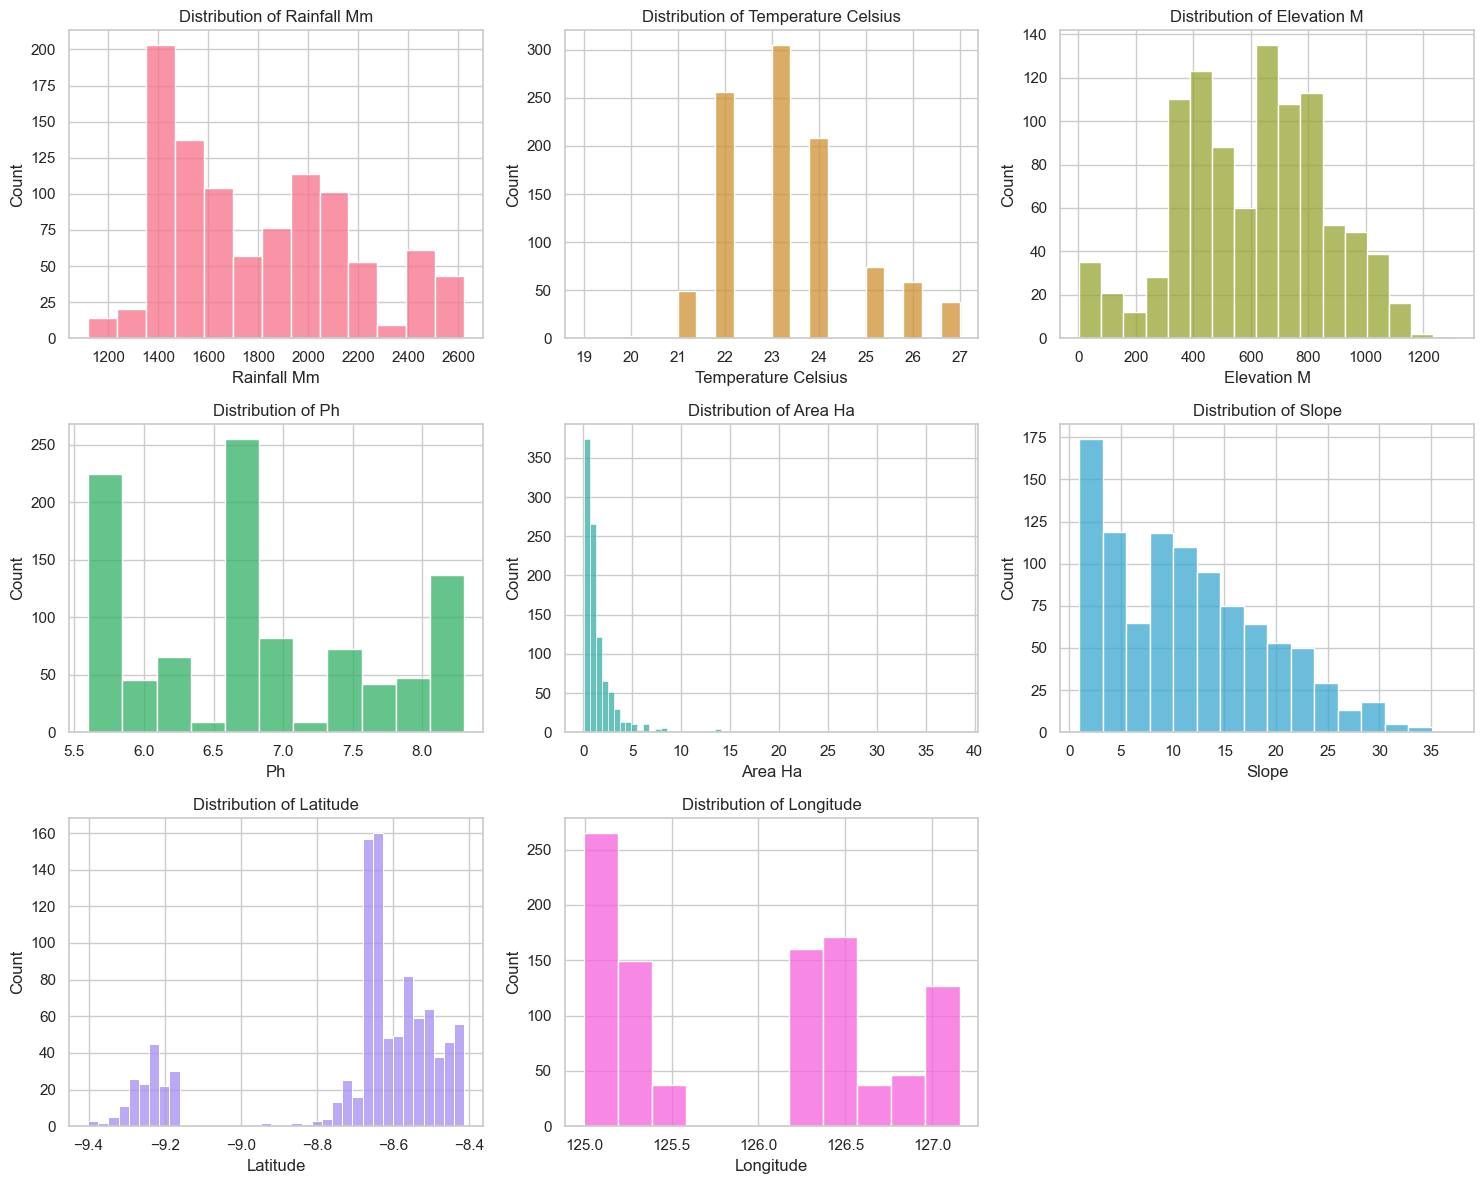

In [12]:
# Plot Numerical Distributions
num_plots = len(farms_numerical_cols)
cols_grid = 3
rows_grid = (num_plots // cols_grid) + (1 if num_plots % cols_grid > 0 else 0)

colors = sns.color_palette("husl", num_plots)

plt.figure(figsize=(15, rows_grid * 4))
for i, col in enumerate(farms_numerical_cols):
    plt.subplot(rows_grid, cols_grid, i + 1)
    sns.histplot(farms_df[col], kde=False, color=colors[i])
    plt.title(f"Distribution of {col.replace('_', ' ').title()}")
    plt.xlabel(col.replace("_", " ").title())
    plt.tight_layout()

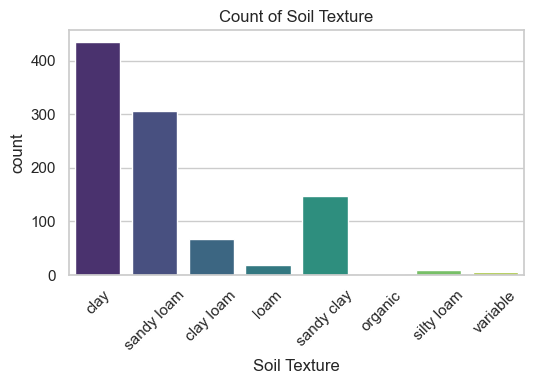

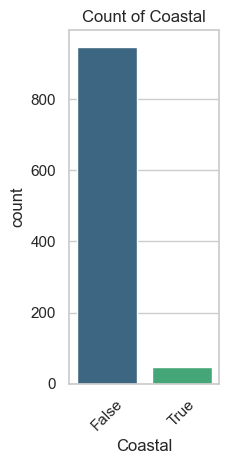

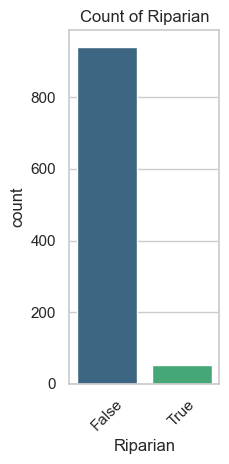

In [13]:
# Plot Categorical Counts
# Check for unique values in categorical columns to avoid overcrowding
valid_farm_cat_cols = [
    col for col in farms_categorical_cols if farms_df[col].nunique() < 20
]

farms_cat_plots = len(valid_farm_cat_cols)
if farms_cat_plots > 0:
    rows_grid_cat = (farms_cat_plots // cols_grid) + (
        1 if farms_cat_plots % cols_grid > 0 else 0
    )

    plt.figure(figsize=(15, rows_grid_cat * 4))
    for i, col in enumerate(valid_farm_cat_cols):
        plt.subplot(rows_grid_cat, cols_grid, i + 1)
        sns.countplot(
            x=farms_df[col], palette="viridis", hue=farms_df[col], legend=False
        )
        plt.title(f"Count of {col.replace('_', ' ').title()}")
        plt.xlabel(col.replace("_", " ").title())
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

### Summary
**Data Structure:**
  * The dataset contains 992 entries and 11 columns.
  * Columns:
      * Identifiers: `id`
      * Numerical: `rainfall_mm`, `temperature_celsius`, `elevation_m`, `ph`, `area`, `latitude`, `longitude`
      * Characteristics (Categorical/Boolean): `soil_texture`, `costal`, `riparian`

**Data Quality:**
  * `latitude` and `longitude`: These columns are completely empty (all 1122 values are missing), so we cannot map the farms geographically.
  * `soil_texture`: There are 16 missing values.
  *  `ph`: There are 4 farms that have a 0 pH, this is likely an error and has been replaced with the NaN.
  * `coastal` and `riparian` show many farms are not coastal or riparian.
  * All other columns are complete.
  * Data types appear appropriate (integers/floats for ranges, booleans for flags).

**Distributions & Statistics:**
  * Rainfall: Varies between 1119 mm and 2623 mm, with an average of \~1790 mm.
  * Temperature: Relatively consistent, ranging from 19°C to 27°C (avg \~23°C).
  * Elevation: Ranges widely from sea level (3m) up to 1312m.
  * pH: After imputation spans from 5.6 to 8.5. The average is 6.8.
  * Farm Size (`area_ha`): Most farms are small (median 0.88 ha), but there are outliers up to 38.48 ha.

**Visualisations:**
  * Numerical Distributions: The histograms show the spread of rainfall, temperature, elevation, pH, and farm size.
  * Categorical Counts: The bar charts shows the breakdown of soil textures (e.g., clay, sandy loam) and boolean traits like `costal` and `riprian`.

## Clustering

### Pre-processing

In [14]:
# Drop rows with missing soil_texture to ensure data integrity for clustering
farms_clean_df = farms_df.dropna(subset=["soil_texture"]).copy()

In [15]:
# Drop rows with soil_texture of "organic" as it doesn't fit the USDA soil texture classification
farms_clean_df = farms_clean_df[farms_clean_df["soil_texture"] != "organic"]

In [16]:
# Replace "variable" soil texture with "loam"
farms_clean_df.loc[
    farms_clean_df["soil_texture"].str.contains("variable", case=False, na=False),
    "soil_texture",
] = "loam"

In [17]:
# In cells were the pH was 0, replace them with the mean
ph_mean = farms_clean_df["ph"].mean()

# Fill the NaNs with the mean of the column
farms_clean_df["ph"] = farms_clean_df["ph"].fillna(ph_mean)

In [18]:
# Drop any columns that have no values, e.g. latitude and longitude
farms_clean_df.dropna(axis="columns", how="any", inplace=True)
print("\nDataFrame after dropping columns with ANY NaN:")
print(farms_clean_df)


DataFrame after dropping columns with ANY NaN:
       id  rainfall_mm  temperature_celsius  elevation_m   ph soil_texture  \
0       1         1958                   23          585  6.2         clay   
1       2         1958                   23          481  6.2         clay   
2       3         2020                   25          179  8.2   sandy loam   
3       4         2553                   24          259  5.9   sandy loam   
4       5         2020                   25          129  7.0         clay   
..    ...          ...                  ...          ...  ...          ...   
987  2889         1209                   26          263  6.7         clay   
988  2890         1209                   26          315  6.7         clay   
989  2891         1725                   23          700  7.4    clay loam   
990  2892         1706                   23          843  7.0         clay   
991  2894         1706                   23          915  6.2         clay   

     area_ha   

### Encoding

In [19]:
# Categorical/Boolean columns
# Convert booleans to int
farms_boolean_cols = ["coastal", "riparian"]
for col in farms_boolean_cols:
    farms_clean_df[col] = farms_clean_df[col].astype(int)

In [20]:
# One-hot encode soil_texture
# Get dummies and ensure we keep track of them
farms_soil_dummies = pd.get_dummies(farms_clean_df["soil_texture"], prefix="soil")

# Remove lat and long for now until data is available
farms_numerical_cols.remove("latitude")
farms_numerical_cols.remove("longitude")

# Remove costal and riparian for now until data is available
farms_boolean_cols.remove("coastal")
farms_boolean_cols.remove("riparian")

# Combine features
farms_features_df = pd.concat(
    [
        farms_clean_df[farms_numerical_cols],
        farms_clean_df[farms_boolean_cols],
        farms_soil_dummies,
    ],
    axis=1,
)

### Scaling

In [21]:
farms_scaler = StandardScaler()
farms_scaled_features = farms_scaler.fit_transform(farms_features_df)

### k-means clustering

In [22]:
# Determine optimal k
farms_K_range = range(2, 6)
farms_best_k = 2
farms_best_score = -1

for k in farms_K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(farms_scaled_features)
    score = silhouette_score(farms_scaled_features, labels)
    if score > farms_best_score:
        farms_best_score = score
        farms_best_k = k

print(
    f"Optimal number of clusters (k) found: {farms_best_k} (Silhouette Score: {farms_best_score:.3f})"
)

Optimal number of clusters (k) found: 5 (Silhouette Score: 0.415)


In [23]:
# Apply KMeans
farms_kmeans = KMeans(n_clusters=farms_best_k, random_state=42, n_init=10)
farms_clean_df["Cluster"] = farms_kmeans.fit_predict(farms_scaled_features)

In [24]:
# Get the centroids of each cluster
farms_centroids = pd.DataFrame(
    farms_kmeans.cluster_centers_, columns=farms_features_df.columns
)

# Calculate the difference between Clusters
# Get the absolute value difference
farms_diff = farms_centroids.diff().iloc[1].abs()

# Sort to find the most important features
farms_sorted_diff = farms_diff.sort_values(ascending=False)

# Display the results
print("Top features driving the farm cluster separation:")
print(farms_sorted_diff.head(6))

Top features driving the farm cluster separation:
soil_sandy clay        2.804454
soil_sandy loam        1.968540
ph                     1.427746
rainfall_mm            0.865920
elevation_m            0.577331
temperature_celsius    0.411249
Name: 1, dtype: float64


In [25]:
# Feature for investigation
farms_features_of_interest = [
    "ph",
    "rainfall_mm",
    "elevation_m",
    "temperature_celsius",
]

# Calculate averages per cluster
farms_summary = farms_clean_df.groupby("Cluster")[farms_features_of_interest].mean().T
farms_summary.columns = [
    "Cluster 0",
    "Cluster 1",
    "Cluster 2",
    "Cluster 3",
    "Cluster 4",
]

print("Key Statistics for Farm Classification:")
print(farms_summary)

Key Statistics for Farm Classification:
                       Cluster 0    Cluster 1    Cluster 2    Cluster 3  \
ph                      5.730341     6.961538     7.285294     6.935619   
rainfall_mm          1889.851351  2209.354515  1708.411765  1527.750000   
elevation_m           653.682432   800.374582   499.529412   483.685841   
temperature_celsius    22.952703    22.364548    23.970588    23.951327   

                       Cluster 4  
ph                      7.277846  
rainfall_mm          1645.782609  
elevation_m           389.782609  
temperature_celsius    23.956522  


In [26]:
# PCA for Visualisation
farms_pca = PCA(n_components=2)
farms_principal_components = farms_pca.fit_transform(farms_scaled_features)
farms_pca_df = pd.DataFrame(data=farms_principal_components, columns=["PC1", "PC2"])
farms_pca_df["Cluster"] = farms_clean_df["Cluster"].values

In [27]:
# Get the correlation between original features and the PCs
farms_loadings = pd.DataFrame(
    farms_pca.components_.T, columns=["PC1", "PC2"], index=farms_features_df.columns
)

# Sort to find the top drivers for each component
farms_top_pc1 = farms_loadings.reindex(
    farms_loadings["PC1"].abs().sort_values(ascending=False).index
).head(10)
farms_top_pc2 = farms_loadings.reindex(
    farms_loadings["PC2"].abs().sort_values(ascending=False).index
).head(10)

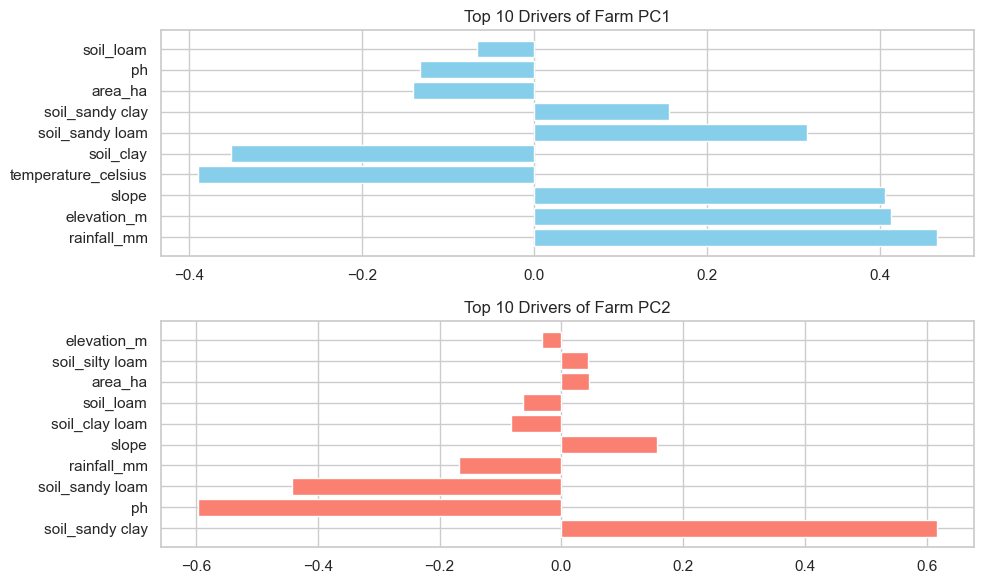

In [28]:
# Plot
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.barh(farms_top_pc1.index, farms_top_pc1["PC1"], color="skyblue")
plt.title("Top 10 Drivers of Farm PC1")

plt.subplot(2, 1, 2)
plt.barh(farms_top_pc2.index, farms_top_pc2["PC2"], color="salmon")
plt.title("Top 10 Drivers of Farm PC2")

plt.tight_layout()

In [29]:
# Analyse Cluster Characteristics
print("\nCluster Averages (Numerical Features):")
print(farms_clean_df.groupby("Cluster")[farms_numerical_cols].mean())

# print("\nCluster Frequencies (Boolean Features):")
# print(farms_clean_df.groupby('Cluster')[farms_boolean_cols].mean())

# Soil Texture Distribution per Cluster
# Group by cluster and then value_counts on the original 'soil_texture' column
print("\nMost Common Soil Texture per Cluster:")
print(
    farms_clean_df.groupby("Cluster")["soil_texture"].agg(
        lambda x: x.value_counts().index[0]
    )
)
print("\nSoil Texture Breakdown per Cluster (Top 3):")
for i in range(farms_best_k):
    print(f"\nCluster {i}:")
    print(
        farms_clean_df[farms_clean_df["Cluster"] == i]["soil_texture"]
        .value_counts()
        .head(3)
    )


Cluster Averages (Numerical Features):
         rainfall_mm  temperature_celsius  elevation_m        ph   area_ha  \
Cluster                                                                      
0        1889.851351            22.952703   653.682432  5.730341  1.512027   
1        2209.354515            22.364548   800.374582  6.961538  0.969699   
2        1708.411765            23.970588   499.529412  7.285294  3.121324   
3        1527.750000            23.951327   483.685841  6.935619  2.016637   
4        1645.782609            23.956522   389.782609  7.277846  1.947826   

             slope  
Cluster             
0        17.414587  
1        16.375089  
2        11.618793  
3         6.507572  
4         5.946836  

Most Common Soil Texture per Cluster:
Cluster
0    sandy clay
1    sandy loam
2     clay loam
3          clay
4          loam
Name: soil_texture, dtype: object

Soil Texture Breakdown per Cluster (Top 3):

Cluster 0:
soil_texture
sandy clay    148
Name: count, dtyp

In [30]:
# Calculate Feature Dominance (Percentage within cluster)
# Cluster 0
cluster_0_data = farms_clean_df[farms_clean_df["Cluster"] == 0]
total_in_cluster_0 = len(cluster_0_data)
clay_farms_in_0 = len(cluster_0_data[cluster_0_data["soil_texture"] == "sandy clay"])

percentage_within_cluster = (clay_farms_in_0 / total_in_cluster_0) * 100
print(f"Percentage of farms with sandy clay soil:{percentage_within_cluster:.1f}%")

# Cluster 1
cluster_1_data = farms_clean_df[farms_clean_df["Cluster"] == 1]
total_in_cluster_1 = len(cluster_1_data)
clay_farms_in_1 = len(cluster_1_data[cluster_1_data["soil_texture"] == "sandy loam"])

percentage_within_cluster = (clay_farms_in_1 / total_in_cluster_1) * 100
print(f"Percentage of farms with sandy loam soil:{percentage_within_cluster:.1f}%")

# Cluster 2
cluster_2_data = farms_clean_df[farms_clean_df["Cluster"] == 2]
total_in_cluster_2 = len(cluster_2_data)
clay_farms_in_2 = len(cluster_2_data[cluster_2_data["soil_texture"] == "clay loam"])

percentage_within_cluster = (clay_farms_in_2 / total_in_cluster_2) * 100
print(f"Percentage of farms with clay loam soil:{percentage_within_cluster:.1f}%")

# Cluster 3
cluster_3_data = farms_clean_df[farms_clean_df["Cluster"] == 3]
total_in_cluster_3 = len(cluster_3_data)
clay_farms_in_3 = len(cluster_3_data[cluster_3_data["soil_texture"] == "clay"])

percentage_within_cluster = (clay_farms_in_3 / total_in_cluster_3) * 100
print(f"Percentage of farms with clay soil:{percentage_within_cluster:.1f}%")

# Cluster 4
cluster_4_data = farms_clean_df[farms_clean_df["Cluster"] == 4]
total_in_cluster_4 = len(cluster_4_data)
clay_farms_in_4 = len(cluster_4_data[cluster_4_data["soil_texture"] == "loam"])

percentage_within_cluster = (clay_farms_in_4 / total_in_cluster_4) * 100
print(f"Percentage of farms with loam soil:{percentage_within_cluster:.1f}%")

Percentage of farms with sandy clay soil:100.0%
Percentage of farms with sandy loam soil:91.0%
Percentage of farms with clay loam soil:100.0%
Percentage of farms with clay soil:90.5%
Percentage of farms with loam soil:100.0%



Five distinct clusters of farms have been identified. The farms are primarily grouped by Soil Texture and Elevation/Rainfall, with secondary influences from pH, slope, and farm size.

### Cluster Profiles

Here is a breakdown of the five farm types:

* Cluster 0: “Acidic Sandy Clay Farms”

  *   Dominant Feature: Sandy clay soil (most common texture).
  *   Environment: Moderate elevation (\~654 m) and high rainfall (\~1,890 mm).
  *   Key Trait: Acidic soil (pH \~5.73), significantly lower than other clusters.
  *   Size: Average farm size \~1.51 ha.
  *   Slope: Steep terrain (\~17.4°), suggesting hilly landscapes.

* Cluster 1: “High-Rainfall Highland Farms”

  *   Dominant Feature: Sandy loam soil.
  *   Environment: Highest elevation (\~800 m) and highest rainfall (\~2,209 mm).
  *   Size: Smaller farms (\~0.97 ha).
  *   Slope: Relatively steep (\~16.4°), typical of upland regions.
  *   pH: Near neutral (\~6.96).

* Cluster 2: “Large Clay Loam Farms”

  *   Dominant Feature: Clay loam soil.
  *   Environment: Moderate elevation (\~500 m) and moderate rainfall (\~1,708 mm).
  *   Size: Largest farms (\~3.12 ha).
  *   pH: Slightly alkaline (\~7.29).
  *   Slope: Moderate (\~11.6°).

* Cluster 3: “Clay Farms in Gentle Terrain”

  *   Dominant Feature: Clay soil.
  *   Environment: Lower elevation (\~484 m) and lower rainfall (\~1,528 mm).
  *   Size: Medium farms (\~2.02 ha).
  *   Slope: Gentle (\~6.5°).
  *   pH: Near neutral (\~6.94).

* Cluster 4: “Loam Farms in Lowlands”

  *   Dominant Feature: Loam soil.
  *   Environment: Lowest elevation (\~390 m) and warmest temperatures (\~24°C).
  *   Size: Medium farms (\~1.95 ha).
  *   Slope: Flattest terrain (\~5.95°).
  *   pH: Slightly alkaline (\~7.28).


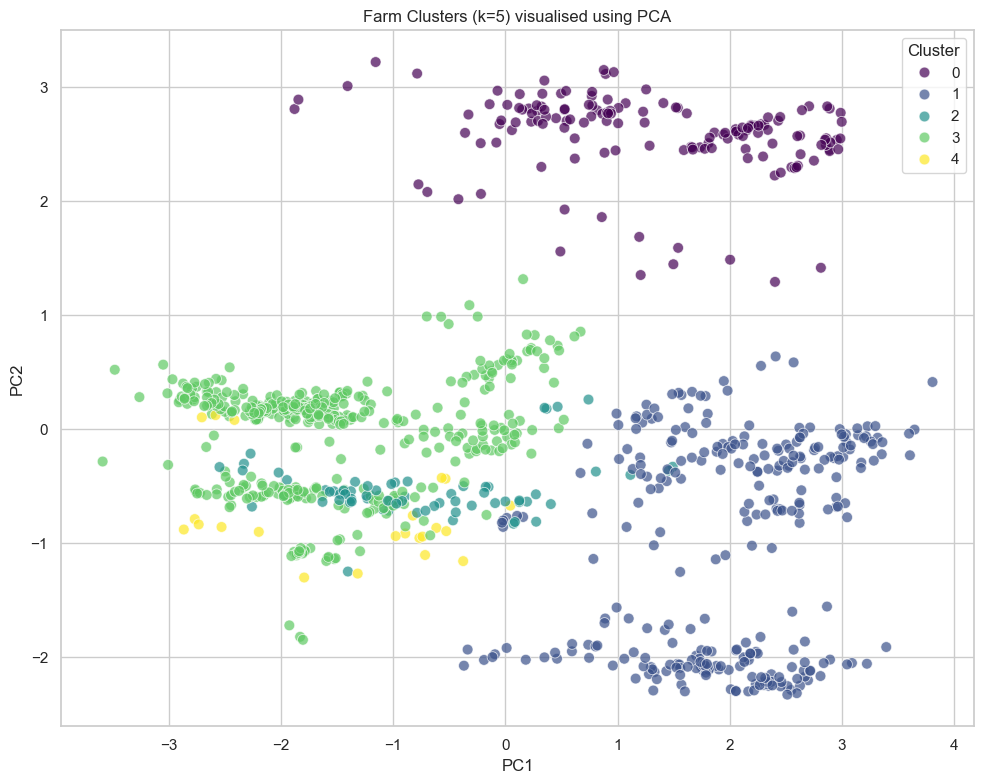

In [31]:
# Plot PCA
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x="PC1",
    y="PC2",
    hue="Cluster",
    data=farms_pca_df,
    palette="viridis",
    s=60,
    alpha=0.7,
)
plt.title(f"Farm Clusters (k={farms_best_k}) visualised using PCA")
plt.tight_layout()

#### Principal components

PC1 captures the primary geographical and climate gradient in the farms.

  * Positive Side (+): Driven by temperature, slope and clay Soil. Farms on this side are warmer have a lower elevation and tend to have clay soil.
  * Negative Side (-): Strongly driven by rainfall and elevation. Farms on this side are high-altitude, high-rainfall sites, and often associated with sandy loam soils.

PC2 captures a specific soil chemistry pattern.

  * Positive Side (+): Driven by sandy clay soil and low pH (acidic).
  * Negative Side (-): Since pH has a negative loading, a lower value on this axis means higher pH (more alkaline), and a higher value (positive side) means lower pH (more acidic).

#### Scatter plot summary

  * Moving Right (PC1 \> 0): Farms that are low, warm and clay soils.
  * Moving Left (PC1 \< 0): Farms that are high, wet and sandy soils.
  * Moving Up (PC2 \> 0): Farms that have acidic sandy clay.
  * Moving Down (PC2 \< 0): Farms that have neutral/alkaline sandy loam soils.


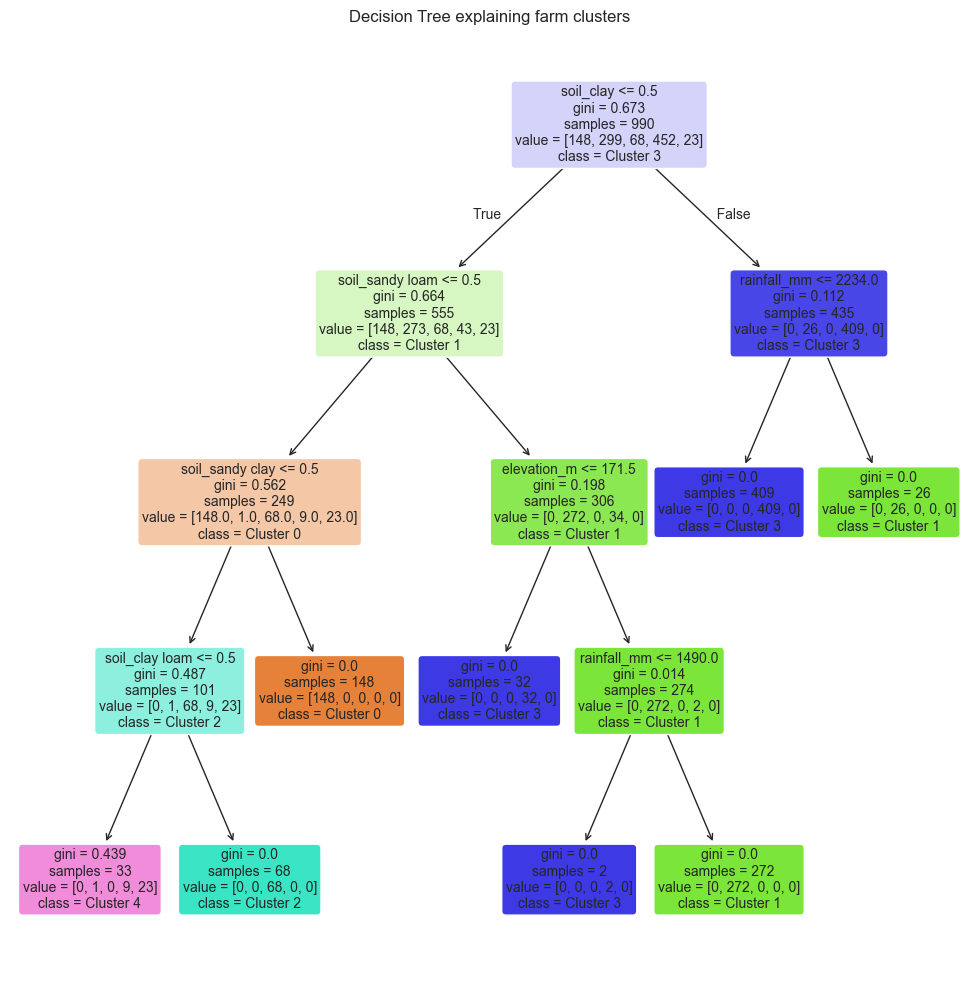

In [32]:
# Train Decision Tree
farm_clf = DecisionTreeClassifier(max_depth=4, random_state=42)
farm_clf.fit(farms_features_df, farms_clean_df["Cluster"])

# Plot the tree
plt.figure(figsize=(10, 10))
plot_tree(
    farm_clf,
    feature_names=farms_features_df.columns,
    class_names=[f"Cluster {i}" for i in range(5)],
    filled=True,
    rounded=True,
    fontsize=10,
)
plt.title("Decision Tree explaining farm clusters")
plt.tight_layout()


### Decision Tree analysis

The tree confirms that soil texture is the most influential factor, followed by rainfall and elevation. These variables drive the separation of clusters.

The rules (Simplified):

Is it clay soil?
  * Yes (clay soil present):
      * Check rainfall:
          *   \<= 2234 mm: Assigned to Cluster 3 (Clay farms in gentle terrain).
          *   \> 2234 mm: Assigned to Cluster 1 (Highland farms with very wet clay soils).
  * No (not clay):
      * Check sandy loam:
          * Yes (sandy loam):
              * Check elevation:
                  * \<= 171.5 m: Assigned to Cluster 1 (Highland sandy loam farms).
                  * \> 171.5 m: Check rainfall:
                      * \<= 1490 mm: Assigned to Cluster 1.
                      * \> 1490 mm: Assigned to Cluster 3.
          * No (not sandy loam):
              * Check for minority soils:
                  *  Sandy clay? -\> Cluster 2 (Acidic sandy clay farms).
                  *  Clay loam? -\> Cluster 4 (Large clay loam farms).
                  *  Loam? -\> Cluster 0 (Loam farms in lowlands).

# Creating a cleaned dataset

In [33]:
# Re-load the dataset
df = pd.read_csv("../../data/farms.csv")

# Perform data clean steps identified in EDA

# Convert the 'soil_texture' column to lowercase
df["soil_texture"] = df["soil_texture"].str.lower()

# Replace "variable" with "loam" to match the possible soil categories
df["soil_texture"] = df["soil_texture"].replace("variable", "loam")

# Replace "organic" with None to allow prediction as it doesn't fit the USDA soil texture classification
df["soil_texture"] = df["soil_texture"].replace("organic", None)

# Fix pH: Replace 0 values with the mean of non-zero values
# Convert ph==0 to NaN (so pandas ignores them)
df["ph"] = df["ph"].replace(0, np.nan)
ph_mean = df["ph"].mean()
df["ph"] = df["ph"].fillna(ph_mean)

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
id                     0
rainfall_mm            0
temperature_celsius    0
elevation_m            0
ph                     0
soil_texture           2
area_ha                0
slope                  0
latitude               0
longitude              0
coastal                0
riparian               0
dtype: int64


In [34]:
# Split the data into two sets
# Set A: Farms where the soil type is known (Training Data)
df_known = df.dropna(subset=["soil_texture"]).copy()

# Set B: Farms where the soil type is missing (Prediction Targets)
df_unknown = df[df["soil_texture"].isnull()].copy()

print(f"Training on {len(df_known)} farms.")
print(f"Predicting for {len(df_unknown)} farms.")

Training on 990 farms.
Predicting for 2 farms.


In [35]:
# Define the features to use for prediction
# Use environmental factors
feature_cols = ["rainfall_mm", "temperature_celsius", "elevation_m", "ph"]

X_train = df_known[feature_cols]
y_train = df_known["soil_texture"]
X_predict = df_unknown[feature_cols]

In [36]:
# Cross validation
clf = RandomForestClassifier(n_estimators=100, random_state=42)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Calculate Scores
scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring="accuracy")
print(f"Minimum Accuracy: {scores.min() * 100:.2f}%")
print(f"Maximum Accuracy: {scores.max() * 100:.2f}%")
print(f"Mean Accuracy: {scores.mean() * 100:.2f}%")

Minimum Accuracy: 92.93%
Maximum Accuracy: 98.99%
Mean Accuracy: 96.77%


<Axes: >

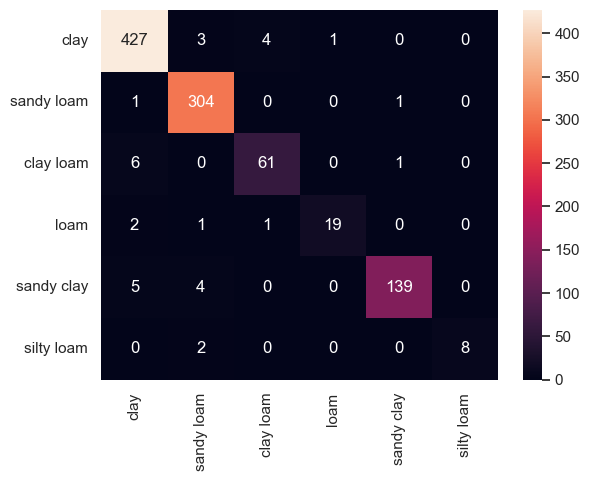

In [37]:
# Plot Confusion Matrix
y_pred = cross_val_predict(clf, X_train, y_train, cv=cv)
cm = confusion_matrix(y_train, y_pred, labels=y_train.unique())
sns.heatmap(
    cm, annot=True, fmt="d", xticklabels=y_train.unique(), yticklabels=y_train.unique()
)

Accuracy Results:

  * Mean Accuracy: 96.8%
  * The model is extremely consistent, with individual fold scores ranging from 92.9% to 99.0%. This confirms that the model is robust and not just over-fitting to a specific subset of the data.

Confusion Matrix Analysis:
  * Diagonal Values: These represent correct predictions. The model gets most soil types right.
  * Off-Diagonal Values: These are the errors.
      * For example, looking at the row for clay, there are a few instances misclassified as sandy loam, clay loam and loam.

In [38]:
final_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train on all data
final_clf.fit(X_train, y_train)

# Make predictions of soil type
predicted_soils = final_clf.predict(X_predict)

In [39]:
# Display Results
results = df_unknown[["id", "rainfall_mm", "elevation_m"]].copy()
results["Predicted_Soil_Texture"] = predicted_soils

print("\nPredictions for missing farms:")
print(results)


Predictions for missing farms:
       id  rainfall_mm  elevation_m Predicted_Soil_Texture
194  1603         1357          357                   clay
334  1758         1357          353                   clay


In [40]:
# Predict the soil texture
df_unknown["soil_texture"] = final_clf.predict(df_unknown[feature_cols])

# Re-combine datasets PCA/Clustering
df_full = pd.concat([df_known, df_unknown])

# Mark which farms were predicted for plotting later
df_full["is_predicted"] = df_full.index.isin(df_unknown.index)

# Update soil One-Hot Encoding
soil_dummies = pd.get_dummies(df_full["soil_texture"], prefix="soil")
features = pd.concat([df_full[farms_numerical_cols], soil_dummies], axis=1)

In [41]:
# Scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [42]:
# Clustering (Re-create the 5 clusters)
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df_full["Cluster"] = kmeans.fit_predict(scaled_features)

In [43]:
# PCA
pca = PCA(n_components=2)
coords = pca.fit_transform(scaled_features)

df_full["PC1"] = coords[:, 0]
df_full["PC2"] = coords[:, 1]

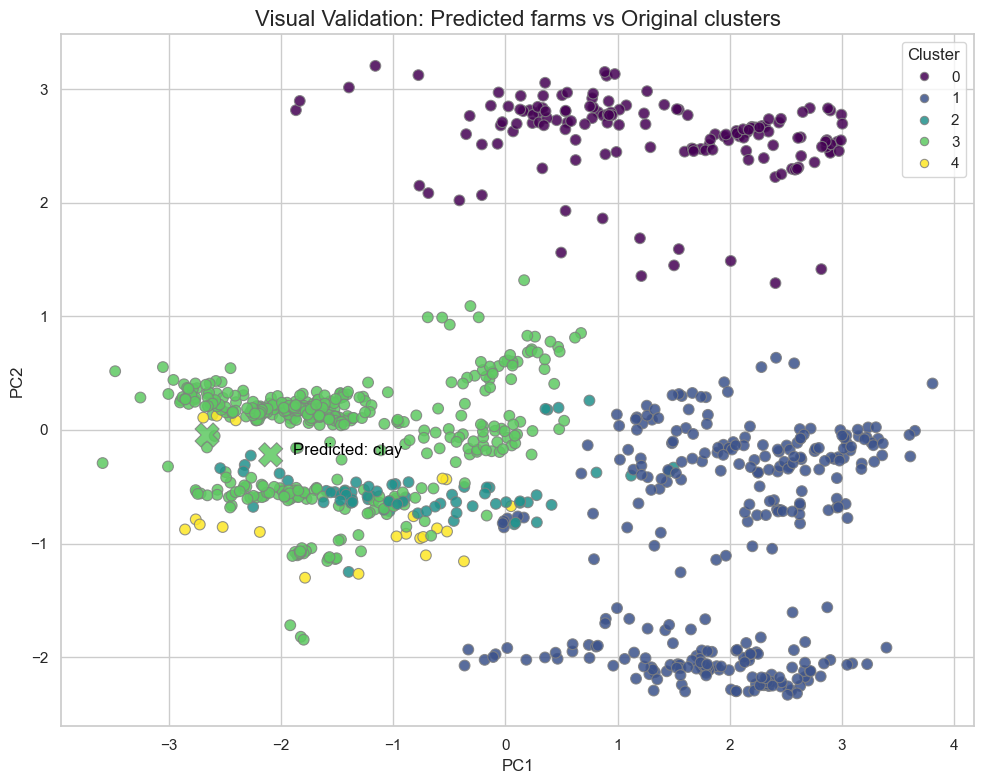

In [44]:
# Cluster number is not guaranteed to be consistent
# I'm going to find the mapping from the new cluster numbering to the old

# The reference numbering from earlier
df_ref = farms_pca_df

# New prediction but only for the known soil texture
original_data = df_full[~df_full["is_predicted"]].copy()

# Create a Confusion Matrix (Intersection of farms)
# Rows = New Clusters, Cols = Ref Clusters
cm = confusion_matrix(original_data["Cluster"], df_ref["Cluster"])

# Find the Best 1-to-1 Mapping
# This finds the combination that maximizes the total overlap
rows, cols = linear_sum_assignment(cm, maximize=True)
mapping = dict(zip(rows, cols))

# Apply the Mapping
original_data["Cluster"] = original_data["Cluster"].map(mapping)

# Plot Predicted Data (prominent)
predicted_data = df_full[df_full["is_predicted"]].copy()

# Apply the Mapping
predicted_data["Cluster"] = predicted_data["Cluster"].map(mapping)


# Combine with a style column
original_data["is_predicted_marker"] = False
predicted_data["is_predicted_marker"] = True
plot_df = pd.concat([original_data, predicted_data], ignore_index=True)

plt.figure(figsize=(10, 8))

ax = sns.scatterplot(
    data=plot_df,
    x="PC1",
    y="PC2",
    hue="Cluster",
    palette="viridis",
    style="is_predicted_marker",
    markers={False: "o", True: "X"},
    size="is_predicted_marker",
    sizes={False: 60, True: 300},
    alpha=0.85,
    edgecolor="grey",
    linewidth=0.8,
)

clusters = sorted(plot_df["Cluster"].unique())
handles, labels = ax.get_legend_handles_labels()
cluster_labels = [f"{c}" for c in clusters]
filtered = [(h, lab) for h, lab in zip(handles, labels) if lab in cluster_labels]
ax.legend(
    [h for h, _ in filtered], [lab for _, lab in filtered], title="Cluster", loc="best"
)

# Add annotations for a few predicted points to confirm logic
# Label a clay prediction
clay_pred = predicted_data[predicted_data["soil_texture"] == "clay"]
if not clay_pred.empty:
    x, y = clay_pred.iloc[0][["PC1", "PC2"]]
    plt.text(x + 0.2, y, "Predicted: clay", fontsize=12, color="black")

# Label a sandy clay prediction
sandy_clay_pred = predicted_data[predicted_data["soil_texture"] == "sandy clay"].head(1)
if not sandy_clay_pred.empty:
    x, y = sandy_clay_pred.iloc[0][["PC1", "PC2"]]
    plt.text(x + 0.2, y, "Predicted: sandy clay", fontsize=12, color="black")

# Label a clay loam prediction
clay_loam_pred = predicted_data[predicted_data["soil_texture"] == "clay loam"].head(1)
if not clay_loam_pred.empty:
    x, y = clay_loam_pred.iloc[0][["PC1", "PC2"]]
    plt.text(x + 0.2, y, "Predicted: clay loam", fontsize=12, color="black")

# Label a loam prediction
loam_pred = predicted_data[predicted_data["soil_texture"] == "loam"].head(1)
if not loam_pred.empty:
    x, y = loam_pred.iloc[0][["PC1", "PC2"]]
    plt.text(x + 0.2, y, "Predicted: loam", fontsize=12, color="black")

plt.title("Visual Validation: Predicted farms vs Original clusters", fontsize=16)

plt.tight_layout()
plt.show()

In [45]:
# Columns not needed in export
columns_to_drop = ["Cluster", "PC1", "PC2"]

# Drop columns
df_export = df_full.drop(columns=columns_to_drop)

# Export to CSV
# index=False prevents the row numbers from being saved as a column
df_export.to_csv("../../data/farms_cleaned.csv", index=False)